In [301]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
import yfinance as yf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [302]:
#dataframe
TICKER = 'GAZP.ME'
N_YEARS = 5
START_DATE = datetime.today() - timedelta(days=N_YEARS * 365)
END_DATE = datetime.today()
WINDOW_SIZE = 12

#prophet
PREDICT_DAYS = 15

In [303]:
df = yf.download(TICKER, start=START_DATE, end=END_DATE, adjusted=True)
df.drop(columns=['Open', 'Low', 'High', 'Close', 'Volume'], inplace=True)
df.rename(columns={'Adj Close': 'price'}, inplace=True)
df_monthly = df.resample('M').last()

[*********************100%***********************]  1 of 1 completed


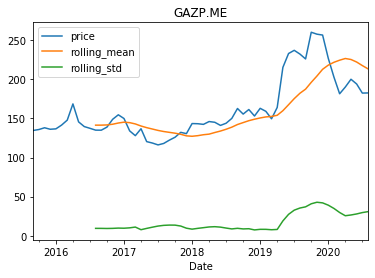

In [304]:
df_monthly['rolling_mean'] = df_monthly.price.rolling(window=WINDOW_SIZE).mean()
df_monthly['rolling_std'] = df_monthly.price.rolling(window=WINDOW_SIZE).std()
df_monthly.plot(title=TICKER)

In [305]:
#prophet prepare data
df_dayly = df.reset_index(drop=False)
df_dayly.rename(columns={'Date': 'ds', 'price': 'y'}, inplace=True)

In [306]:
#train set
train_df = df_dayly[:-PREDICT_DAYS]

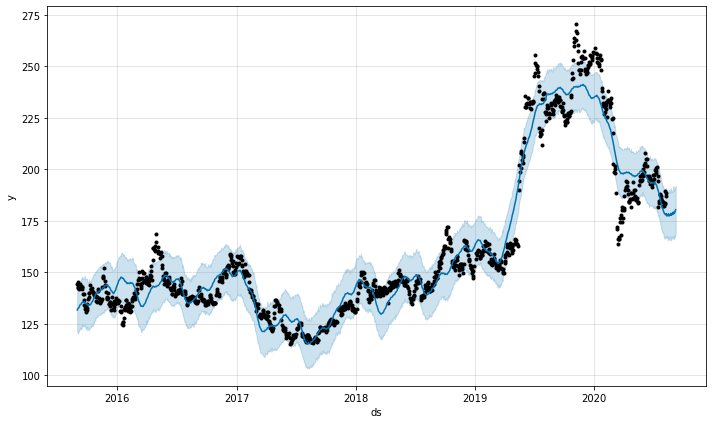

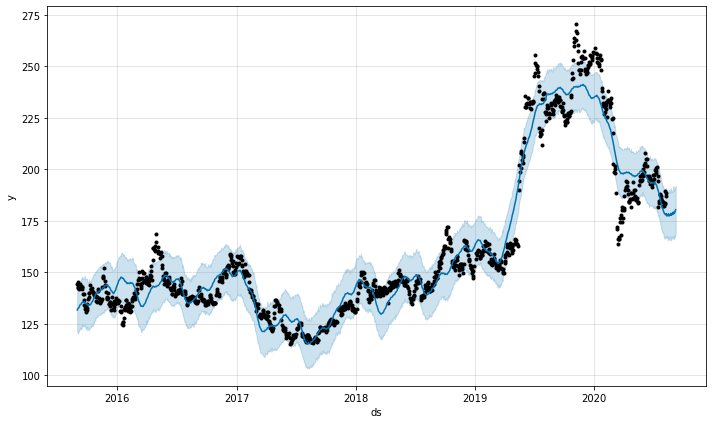

In [307]:
#model
m = Prophet(daily_seasonality=True)
m.fit(train_df)
future = m.make_future_dataframe(periods=PREDICT_DAYS*2)
forecast = m.predict(future)
m.plot(forecast)

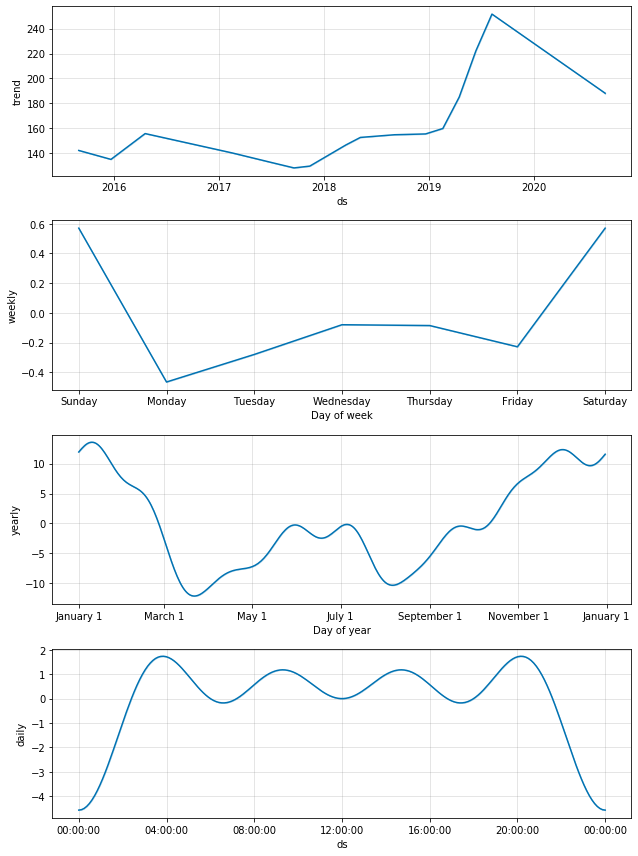

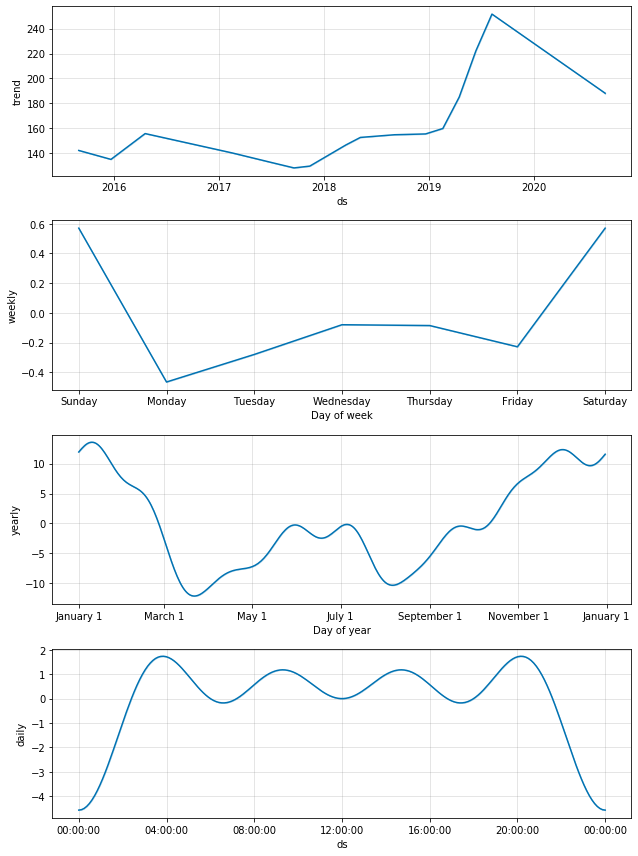

In [308]:
m.plot_components(forecast)

In [309]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_dayly.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE', np.mean(abs(cmp_df[-PREDICT_DAYS:]['p'])))
print ('MAE', np.mean(abs(cmp_df[-PREDICT_DAYS:]['e'])))

MAPE 3.950832292142657
MAE 7.356796350816671


[Text(0, 0, '31-8'),
 Text(0, 0, '1-9'),
 Text(0, 0, '2-9'),
 Text(0, 0, '3-9'),
 Text(0, 0, '4-9'),
 Text(0, 0, '5-9'),
 Text(0, 0, '6-9')]

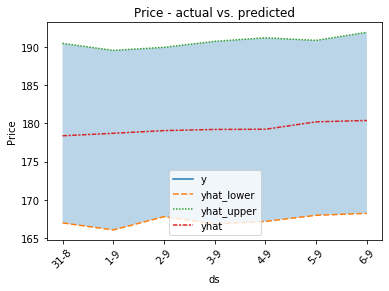

In [310]:
df_acc = cmp_df[-int(PREDICT_DAYS/2):]
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_acc[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(df_acc.index, df_acc.yhat_lower, df_acc.yhat_upper, alpha=0.3)
ax.set(title='Price - actual vs. predicted', ylabel='Price')
ax.set_xticklabels(labels=df_acc.index.map(lambda x: '{}-{}'.format(x.day, x.month)), rotation=45)